In [1]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from sklearn import linear_model
from matplotlib.ticker import PercentFormatter
from matplotlib import colors
import matplotlib
from scipy.signal import find_peaks
import os
import pandas as pd

In [2]:
global PATH  

In [3]:
def refer_to_fat(input_img, cut_1, cut_2, cut_3):
    peaks1, _ = find_peaks(input_img[cut_1], height=0)
    peaks2, _ = find_peaks(input_img[cut_2], height=0)
    peaks3, _ = find_peaks(input_img[cut_3], height=0)
    fat_array = [peaks1[0],peaks1[-1], peaks2[0],peaks2[-1],peaks3[0],peaks3[-1]] #store all the peaks
    fat_array = [i for i in fat_array if i!=0]
    fat_array.remove(max(fat_array))
    fat_array.remove(min(fat_array))

    input_img = input_img/np.mean(fat_array)
#     print(np.mean(fat_array))
    return np.array(input_img)

In [4]:
def store_region(img_ROI, img_VIF, ROI_center, VIF_center_list, ROI_radius, VIF_radius):
    ROI = []
    VIF = []
    for i in range(0,144):
        for j in range(0,144):
            if (i-ROI_center[0])**2+(j-ROI_center[1])**2<=ROI_radius**2:
                if img_ROI[i][j] == 0:
                    tmp = img_ROI[i-3:i+2,j-3:j+2]
                    ROI.append(np.mean(tmp)+1e-10)
                else:
                    ROI.append(img_ROI[i][j])
    for VIF_center in VIF_center_list:
        for i in range(0,144):
            for j in range(0,144):
                if (i-VIF_center[0])**2+(j-VIF_center[1])**2<=VIF_radius**2:
                    if img_VIF[i][j] == 0:
                        tmp = img_VIF[i-3:i+2,j-3:j+2]
                        VIF.append(np.mean(tmp)+1e-10)
                    else: 
                        VIF.append(img_VIF[i][j])
#     print(VIF)           
    return np.array(ROI), np.mean(VIF)

In [5]:
def concerntration_in_tissue(start_cut, end_cut, center, radius,cut_1,cut_2,cut_3,ROI):
#     print('===ROI===')
#     print(ROI)# 1409, 1473
    c_t = []
    for file_name in range(start_cut, end_cut):
        file = pydicom.read_file(PATH+str(file_name))
        img = file.pixel_array
        img = refer_to_fat(img,cut_1,cut_2,cut_3)
        ROI_t = []
        
        for i in range(0,144):
            for j in range(0,144):
                if (i-center[0])**2+(j-center[1])**2<=radius**2:
                    if img[i][j] <= 1e-3:
                        tmp = img[i-3:i+2,j-3:j+2]
                        ROI_t.append(np.mean(tmp)+1e-10)
                    else:
                        ROI_t.append(img[i][j])
        ROI_t = np.array(ROI_t)
#         print('===ROIt===')
#         print(str(file_name))
#         print(ROI_t)
        
        c_t_tmp = np.zeros(len(ROI_t))
        for i in range(len(c_t_tmp)):
            if (ROI_t[i] == 0) & (ROI[i] == 0):
                c_t_tmp[i] = 0
            else:
                
                c_t_tmp[i] = -np.log(ROI_t[i]/ROI[i])
#                 if c_t_tmp[i] >= 3:
                    
#                     print("ROI = ", ROI[i])
#                     print("ROI_t = ", ROI_t[i])
#                     print('===================')
#                     print(c_t_tmp[i])
#                     print('===================')
#         print('****************************************************')            
        c_t.append(c_t_tmp)
    return np.array(c_t)  

In [6]:
def concerntration_in_AIF(start_cut, end_cut, center_list, radius, cut_1,cut_2,cut_3,AIF, ROI_size): # 769, 833
    c_p = []
    for file_name in range(start_cut,end_cut):
        file = pydicom.read_file(PATH+str(file_name))
        img = file.pixel_array
        img = refer_to_fat(img,cut_1,cut_2,cut_3)
#         print('DONE_concerntration_in_plassma')
       
        AIF_t = []
        for center in center_list:
            for i in range(0,144):
                for j in range(0,144):
                    if (i-center[0])**2+(j-center[1])**2<=radius**2:
                        if img[i][j] == 0:
                            tmp = img[i-3:i+2,j-3:j+2]
                            AIF_t.append(np.mean(tmp)+1e-10)
                        else:
                            AIF_t.append(img[i][j])
        AIF_t = np.mean(AIF_t)
# #         print(VIF_t)
        if (AIF_t == 0) & (AIF == 0):
            c_p_tmp = 0
        else:
            c_p_tmp = -np.log(AIF_t/AIF)
#         c_p_tmp = np.zeros(len(VIF_t))
#         for i in range(len(c_p_tmp)):
#             if (VIF_t[i] == 0) & (VIF[i] == 0):
#                 c_p_tmp[i] = 0
#             elif (VIF_t[i] == 0):
#                 c_p_tmp[i] = -1e+5
#             elif (VIF[i] == 0):
#                 c_p_tmp[i] = 1e+5
#             else:
#                 c_p_tmp[i] = -np.log(VIF_t[i]/VIF[i])
        c_p.append([np.mean(c_p_tmp) for i in range(ROI_size)])
    return np.array(c_p)

In [7]:
def compute_K_i(ROI, c_p, abbandon_list, y):
    Ki = []
    for i in range(len(ROI)):
        c_p_tmp = c_p[:,i]+1e-10
        per_time = 0
        y_t = []
        x_t = []
        for time in range(len(c_p_tmp)):
            if time not in abbandon_list: 
                if time <= 16: 
                    per_time += c_p_tmp[time]*(4/60)
                    y_t.append(y[:,i][time])
                    x_t.append(per_time/(c_p_tmp[time]))
                elif (time>16)&(time<=35):
                    per_time += c_p_tmp[time]*(6/60)
                    y_t.append(y[:,i][time])
                    x_t.append(per_time/(c_p_tmp[time]))
                elif (time>35)&(time<=41):
                    per_time += c_p_tmp[time]*(8/60)
                    y_t.append(y[:,i][time])
                    x_t.append(per_time/(c_p_tmp[time]))
                elif (time>41):
                    per_time += c_p_tmp[time]
                    y_t.append(y[:,i][time])
                    x_t.append(per_time/(c_p_tmp[time]))
        x_t = np.array(x_t)
        y_t = np.array(y_t)

        y_t_mean = np.mean(y_t)
        y_t_std = np.std(y_t)

        drop_index = []
        for index in range(len(y_t)):
            if abs(y_t[index]-y_t_mean)>y_t_std:
                drop_index.append(index)

        y_t = np.delete(y_t, drop_index)
        x_t = np.delete(x_t, drop_index)
#         plt.scatter(x_t, y_t)
#         plt.show()
        regr = linear_model.LinearRegression()
#         print(x_t)
#         print(y_t)
        regr.fit(x_t.reshape(-1,1), y_t)
        Ki.append(round(regr.coef_[0],5))
    return np.array(Ki)


In [8]:
def substract_Ki(Ki, bin_num):
#     plt.clf()
#     print(Ki)
    plot1 = np.histogram(Ki[Ki>=0], bins=bin_num , range = (0, np.max(np.abs(Ki))))
    
    plot2 = np.histogram(-1*Ki[Ki<0], bins = plot1[1])
    
#     plt.clf()
    bar1 = plot1[0]
    bar2 = plot2[0]
    print(np.sum(bar1+bar2))
    substr_bar = np.zeros(len(bar1))
    for i in range(len(bar1)):
        if (bar1[i]-bar2[i]) < 0:
            substr_bar[i] = 0
        else:
            substr_bar[i] = bar1[i]-bar2[i]
    return [substr_bar/len(Ki), plot1[1],bar1/len(Ki),bar2/len(Ki)]

In [9]:
def main_AIF(PATH, start_ROI, start_AIF, center_ROI, center_AIF, radius_ROI, radius_AIF, cut_1, cut_2, cut_3,bins):
    init_ROI = pydicom.read_file(PATH+str(start_ROI))
    pixel_ROI = init_ROI.pixel_array
    
    init_AIF = pydicom.read_file(PATH+str(start_AIF))
    pixel_AIF = init_AIF.pixel_array
    
    pixel_AIF = refer_to_fat(pixel_AIF,cut_1, cut_2, cut_3)
    pixel_ROI = refer_to_fat(pixel_ROI,cut_1, cut_2, cut_3)
    
    ROI, AIF = store_region(pixel_ROI, pixel_AIF, center_ROI, center_AIF, radius_ROI, radius_AIF)
#     print(ROI)
    c_t = concerntration_in_tissue(start_ROI,start_ROI+64,center_ROI,radius_ROI, cut_1, cut_2, cut_3, ROI)
#     print((c_t[1]))
#     print(len(c_t[0]))
    ROI_size = len(ROI)
    c_p = concerntration_in_AIF(start_AIF, start_AIF+64,center_AIF,radius_AIF, cut_1, cut_2, cut_3, AIF, ROI_size)
#     print(c_p[1])
#     print(c_p[2])
#     print(len(c_p[0]))
    y = (c_t+1e-10)/(c_p+1e-10)
#     print('cp_= ',np.max(c_p))
#     print('ct_= ',np.max(c_t))
#     print(y)
#     drop_list = [10,11,13,17,27,34,37,44,46,50,54,56,59]
    drop_list = []
    Ki = compute_K_i(ROI, c_p, drop_list, y)
    print('len(ki)=',len(Ki))
    sub = substract_Ki(Ki,bins)
    return [sub[0], sub[1], sub[2], sub[3]]

In [12]:
import xlrd
### read path
ex_file = xlrd.open_workbook('D:\\Brain_PR\\tmp\\CSVD 10409805 PVWM-20190718T141019Z-001\\CSVD 10409805 PVWM\\10409805.xlsx')
label_loc = ex_file.sheets()[0]
nrow = label_loc.nrows
info = []
for i in range(0,nrow):
    info.append([num.value for num in label_loc.row(i)])
info

[[1089.0, 'RF', 56.2, 44.6],
 [1089.0, 'LF', 87.6, 43.8],
 [1089.0, 'RP', 53.6, 93.0],
 [1089.0, 'LP', 89.8, 93.8],
 [577.0, 'RO', 58.2, 109.6],
 [577.0, 'LO', 87.2, 113.0],
 [833.0, 'RCH', 61.6, 57.4],
 [833.0, 'LCH', 83.8, 57.6],
 [833.0, 'RBG', 55.8, 67.6],
 [833.0, 'LBG', 91.2, 69.6],
 [833.0, 'RTH', 62.8, 77.8],
 [833.0, 'LTH', 81.4, 77.4],
 [513.0, 'AIF', 63.2, 63.0],
 [513.0, 'AIF', 61.8, 61.6],
 [513.0, 'AIF', 59.4, 60.2]]

In [13]:
# VIF_label_list = np.array(info[-3::])
AIF_label_list = np.array(info[-3::])
ROI_label_list = np.array(info[0:-3])
AIF_label_list

array([['513.0', 'AIF', '63.2', '63.0'],
       ['513.0', 'AIF', '61.8', '61.6'],
       ['513.0', 'AIF', '59.4', '60.2']], dtype='<U32')

In [200]:
ROI_label_list

array([['1153.0', 'RF', '56.6', '49.4'],
       ['1153.0', 'LF', '86.6', '50.0'],
       ['1153.0', 'RP', '58.2', '95.6'],
       ['1153.0', 'LP', '89.6', '93.8'],
       ['577.0', 'RO', '55.6', '112.0'],
       ['577.0', 'LO', '84.6', '113.8'],
       ['961.0', 'RCH', '63.0', '61.2'],
       ['961.0', 'LCH', '83.6', '61.6'],
       ['961.0', 'RBG', '56.2', '71.2'],
       ['961.0', 'LBG', '90.6', '70.2'],
       ['961.0', 'RTH', '65.6', '78.4'],
       ['961.0', 'LTH', '83.4', '78.0']], dtype='<U32')

In [14]:
def pertubation(input_list):
    return [np.array(input_list.astype('float').astype('int')),
                np.array(input_list.astype('float').astype('int'))+np.array([1,0])]
#                 np.array(input_list.astype('float').astype('int'))+np.array([2,1])]
#                 np.array(input_list.astype('float').astype('int'))+np.array([1,2])]

In [15]:
AIF_center_list = AIF_label_list[::,2::].astype('float').astype('int')
AIF_center_list

array([[63, 63],
       [61, 61],
       [59, 60]])

In [16]:
ROI_label_list[1][2::]

array(['87.6', '43.8'], dtype='<U32')

## 計算AIF的

len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81


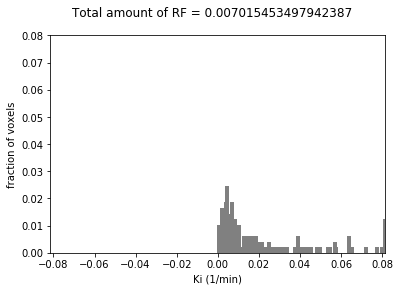

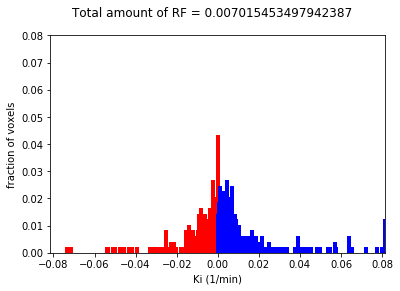

len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81


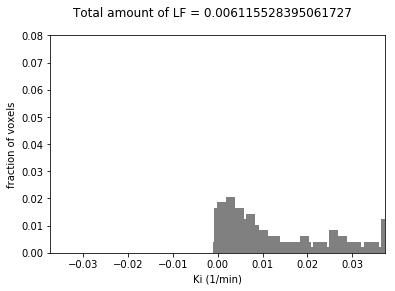

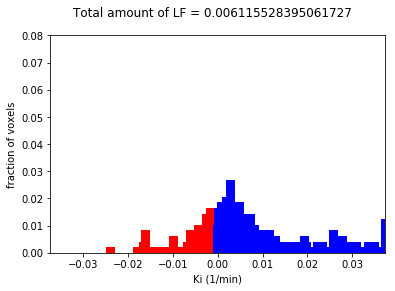

len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81


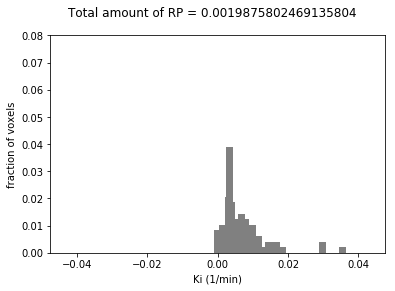

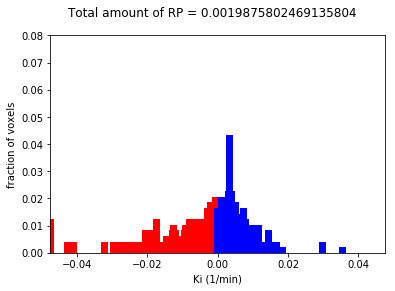

len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81


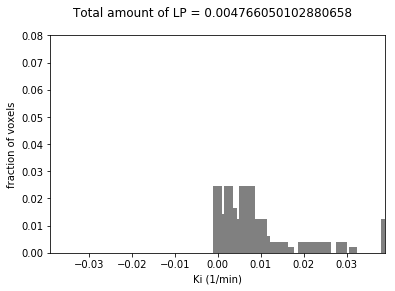

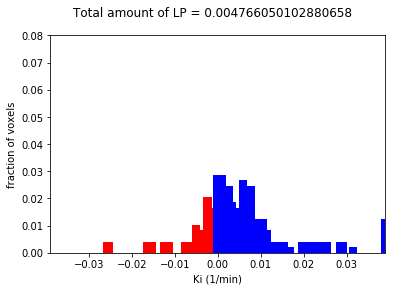

len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81
len(ki)= 81
81


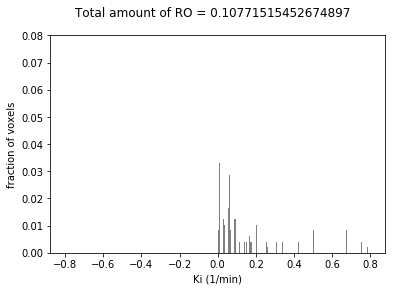

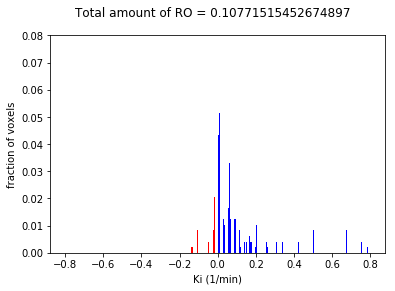

In [ ]:
PATH = "D:\\Brain_PR\\tmp\\CSVD 10409805 PVWM-20190718T141019Z-001\\CSVD 10409805 PVWM\\S11010\\"
# dir_name = 'control '
# pid = '00503821\\'
# PATH = "D:\\Brain_PR\\"+dir_name+pid+"\\"
if os.path.exists(PATH+'AIF_full_seq\\') == False:
    os.makedirs(PATH+'AIF_full_seq\\')
result_mean = []
for ROI_label in range(len(ROI_label_list)):
    
    ROI_center_list = pertubation(ROI_label_list[ROI_label][2::])
    cut = [[70,85,90],
            [75,80,90],
            [74,87,95],
            ]
    substract_arr = []
    positive = []
    negetive = []
    
    Start_ROI = ROI_label_list[ROI_label][0].astype(float).astype(int)
    Start_AIF = AIF_label_list[0][0].astype(float).astype(int)
    
    label = ROI_label_list[ROI_label][1]

    for R_cen in ROI_center_list:
        for cut_row in cut:
#             print(R_cen)
            result = main_AIF(PATH, Start_ROI, Start_AIF, R_cen, AIF_center_list, 5, 3,cut_row[0], cut_row[1], cut_row[2],200)
            
            substract_arr.append(result[0])
            positive.append(result[2])
            negetive.append(result[3])
            
    bins = result[1][0:-1]
    # bins = np.linspace(0,np.max(np.mean(substract_arr, axis=0)),200)
    # bins = main(PATH, 1409, 769, [57,61],[55,63], 8, 8, 70,85,90,200)[1][0:-1]
    plt.clf()
    plt.bar(bins,np.mean(substract_arr, axis=0),width = 0.002,color = 'grey')

    plt.xlim(-max(bins), max(bins))
    plt.ylim(0, 0.08)
    plt.suptitle('Total amount of '+label+' = '+str(np.sum(bins*np.mean(substract_arr, axis=0))))
    plt.xlabel('Ki (1/min)')
    plt.ylabel('fraction of voxels')
    plt.savefig(PATH+'AIF_full_seq\\' +label+' after subtraction.png')
    plt.show()
    plt.clf()
    plt.bar(-1*bins,np.mean(negetive, axis=0),width = 0.002,color = 'r')
    plt.bar(bins,np.mean(positive, axis=0),width = 0.002,color = 'b')
    plt.xlim(-max(bins), max(bins))
    plt.ylim(0, 0.08)
    plt.suptitle('Total amount of '+label+' = '+str(np.sum(bins*np.mean(substract_arr, axis=0))))
    plt.xlabel('Ki (1/min)')
    plt.ylabel('fraction of voxels')
    plt.savefig(PATH+'AIF_full_seq\\' +label+' before subtraction.png')
    plt.show()
    result_mean.append([label, np.sum(bins*np.mean(substract_arr, axis=0))])

In [205]:
df = pd.DataFrame(result_mean)
df.columns = ['location', 'mean of Ki']
df = df.set_index(['location'])
df.to_csv(PATH+'AIF_full_seq\\' +'result of AIF full sequence.csv')